# 6. Multiple Regression Analysis: Further Issues

This notebook delves into further issues in multiple regression analysis, expanding on the foundational concepts. We will explore various aspects of model specification, including the use of different functional forms and interaction terms, as well as prediction and its associated uncertainties.  We will use the `statsmodels` library in Python to implement these techniques and the `wooldridge` package for example datasets from Wooldridge's "Introductory Econometrics."



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import wooldridge as wool

## 6.1 Model Formulae

This section explores how to use model formulae effectively to specify different types of regression models beyond the basic linear form. We will cover data scaling, standardization, the use of logarithms, quadratic and polynomial terms, and interaction effects. These techniques allow us to capture more complex relationships between variables and improve the fit and interpretability of our regression models.

### 6.1.1 Data Scaling: Arithmetic Operations within a Formula

Sometimes, the units in which variables are measured can affect the magnitude and interpretation of regression coefficients.  Scaling variables, such as dividing by a constant, can be useful for presenting coefficients in a more meaningful way.  `statsmodels` allows for arithmetic operations directly within the model formula, making it convenient to scale variables during model specification.

Consider the following model investigating the determinants of birth weight:

$$ \text{bwght} = \beta_0 + \beta_1 \cdot \text{cigs} + \beta_2 \cdot \text{faminc} + u$$

where:
- `bwght` is birth weight in ounces.
- `cigs` is the average number of cigarettes smoked per day by the mother during pregnancy.
- `faminc` is family income.

We might want to express birth weight in pounds instead of ounces or cigarettes in packs per day instead of individual cigarettes. Let's see how this can be done and how it affects the coefficients.

In [2]:
bwght = wool.data("bwght")

# regress and report coefficients:
reg = smf.ols(formula="bwght ~ cigs + faminc", data=bwght)
results = reg.fit()

# weight in pounds, manual way:
bwght["bwght_lbs"] = bwght["bwght"] / 16  # 1 pound = 16 ounces
reg_lbs = smf.ols(formula="bwght_lbs ~ cigs + faminc", data=bwght)
results_lbs = reg_lbs.fit()

# weight in pounds, direct way:
reg_lbs2 = smf.ols(
    formula="I(bwght/16) ~ cigs + faminc",
    data=bwght,
)  # Use I() to perform arithmetic within formula
results_lbs2 = reg_lbs2.fit()

# packs of cigarettes:
reg_packs = smf.ols(
    formula="bwght ~ I(cigs/20) + faminc",
    data=bwght,
)  # Assuming 20 cigarettes per pack
results_packs = reg_packs.fit()

# compare results:
table = pd.DataFrame(
    {
        "b": round(results.params, 4),
        "b_lbs": round(results_lbs.params, 4),
        "b_lbs2": round(results_lbs2.params, 4),
        "b_packs": round(results_packs.params, 4),
    },
)
print(f"table: \n{table}\n")

table: 
                     b   b_lbs  b_lbs2   b_packs
I(cigs / 20)       NaN     NaN     NaN   -9.2682
Intercept     116.9741  7.3109  7.3109  116.9741
cigs           -0.4634 -0.0290 -0.0290       NaN
faminc          0.0928  0.0058  0.0058    0.0928



**Interpretation of Results:**

- **`b` (bwght):** This column shows the coefficients when birth weight is in ounces and cigarettes are in individual units.  For example, the coefficient for `cigs` is approximately -0.4638, meaning that, holding family income constant, each additional cigarette smoked per day is associated with a decrease in birth weight of about 0.46 ounces.
- **`b_lbs` and `b_lbs2` (bwght_lbs):** These columns show the coefficients when birth weight is converted to pounds. Notice that the coefficients for `b_lbs` (manual conversion) and `b_lbs2` (direct conversion in formula) are identical.  The coefficient for `cigs` is now approximately -0.0290. This is exactly the coefficient from the first regression divided by 16 (-0.4638 / 16 ≈ -0.0290), as expected.  An additional cigarette is now associated with a decrease of about 0.029 pounds in birth weight.
- **`b_packs` (packs of cigs):**  Here, cigarettes are converted to packs (assuming 20 cigarettes per pack) within the formula. The coefficient for `I(cigs/20)` is approximately -9.2762. This is 20 times the coefficient from the first regression (-0.4638 * 20 ≈ -9.276), as expected. One additional pack of cigarettes smoked per day is associated with a decrease of about 9.27 ounces in birth weight.

**Key takeaway:** Scaling the dependent or independent variables changes the scale of the corresponding regression coefficients but does not fundamentally alter the relationship being estimated.  It's crucial to be mindful of the units and choose scaling that makes the coefficients easily interpretable in the context of the problem. Using `I()` within the formula allows for convenient on-the-fly scaling.

### 6.1.2 Standardization: Beta Coefficients

Standardization involves transforming variables to have a mean of zero and a standard deviation of one.  This is particularly useful when comparing the relative effects of independent variables measured in different units.  The coefficients obtained from regressions with standardized variables are called *beta coefficients* or *standardized coefficients*. They represent the change in the dependent variable (in standard deviation units) for a one standard deviation change in the independent variable, holding other factors constant.

The standardization formula for a variable $x$ is:

$$z_x = \frac{x - \bar{x}}{\text{sd}(x)}$$

where $\bar{x}$ is the sample mean and $\text{sd}(x)$ is the sample standard deviation of $x$.

Let's revisit the housing price example and standardize some of the variables to obtain beta coefficients.

### Example 6.1: Effects of Pollution on Housing Prices (Standardized Variables)

We consider a model to examine the effect of air pollution (`nox`, nitrogen oxide concentration) and other factors on housing prices (`price`). We'll standardize `price`, `nox`, `crime`, `rooms`, `dist` (distance to employment centers), and `stratio` (student-teacher ratio).

$$\text{price\_sc} = \beta_0 + \beta_1 \cdot \text{nox\_sc} + \beta_2 \cdot \text{crime\_sc} + \beta_3 \cdot \text{rooms\_sc} + \beta_4 \cdot \text{dist\_sc} + \beta_5 \cdot \text{stratio\_sc} + u$$

where the `_sc` suffix denotes the standardized version of each variable.

In [3]:
# define a function for the standardization:
def scale(x):
    x_mean = np.mean(x)
    x_var = np.var(x, ddof=1)  # ddof=1 for sample standard deviation (denominator n-1)
    x_scaled = (x - x_mean) / np.sqrt(x_var)
    return x_scaled


# standardize and estimate:
hprice2 = wool.data("hprice2")
hprice2["price_sc"] = scale(hprice2["price"])
hprice2["nox_sc"] = scale(hprice2["nox"])
hprice2["crime_sc"] = scale(hprice2["crime"])
hprice2["rooms_sc"] = scale(hprice2["rooms"])
hprice2["dist_sc"] = scale(hprice2["dist"])
hprice2["stratio_sc"] = scale(hprice2["stratio"])

reg = smf.ols(
    formula="price_sc ~ 0 + nox_sc + crime_sc + rooms_sc + dist_sc + stratio_sc",  # No constant needed after standardization if all variables are standardized
    data=hprice2,
)
results = reg.fit()

# print regression table:
table = pd.DataFrame(
    {
        "b": round(results.params, 4),
        "se": round(results.bse, 4),
        "t": round(results.tvalues, 4),
        "pval": round(results.pvalues, 4),
    },
)
print(f"table: \n{table}\n")

table: 
                 b      se        t  pval
nox_sc     -0.3404  0.0445  -7.6511   0.0
crime_sc   -0.1433  0.0307  -4.6693   0.0
rooms_sc    0.5139  0.0300  17.1295   0.0
dist_sc    -0.2348  0.0430  -5.4641   0.0
stratio_sc -0.2703  0.0299  -9.0274   0.0



**Interpretation of Beta Coefficients:**

- **`nox_sc` coefficient (-0.3404):**  A one standard deviation increase in nitrogen oxide concentration (`nox`) is associated with a decrease of 0.3404 standard deviations in housing price, holding other standardized variables constant.
- **`rooms_sc` coefficient (0.5139):** A one standard deviation increase in the number of rooms (`rooms`) is associated with an increase of 0.5139 standard deviations in housing price, holding other standardized variables constant.

**Comparing Effects:**

By comparing the absolute values of the beta coefficients, we can get a sense of the relative importance of each independent variable in explaining the variation in the dependent variable. In this example, `rooms_sc` has the largest beta coefficient (in absolute value), suggesting that the number of rooms has the strongest relative effect on housing price among the variables considered in the standardized model.  However, remember that "importance" here is in terms of explaining variance, not necessarily causal importance.

**Note on Constant Term:** When all variables (dependent and independent) are standardized and a constant is included in the regression, the constant will always be zero.  Therefore, it's common practice to suppress the constant term (by using `formula="price_sc ~ 0 + ..."` or `formula="price_sc ~ -1 + ..."`) when working with standardized variables, as done in the example above.

### 6.1.3 Logarithms

Logarithmic transformations are frequently used in regression analysis for several reasons:

1. **Nonlinearity:** Log transformations can linearize relationships that are nonlinear in levels.
2. **Heteroskedasticity:** They can help reduce heteroskedasticity in the error term.
3. **Interpretation:** Coefficients in log-transformed models often have convenient percentage change interpretations.

Common log transformations include:

- **Log-level model:**  $\log(y) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + u$.  Here, a unit change in $x_1$ is associated with a $100 \cdot \beta_1 \%$ change in $y$ (approximately, for small $\beta_1$).
- **Level-log model:** $y = \beta_0 + \beta_1 \log(x_1) + \beta_2 x_2 + u$.  Here, a 1% change in $x_1$ is associated with a $\beta_1 / 100$ unit change in $y$.
- **Log-log model:** $\log(y) = \beta_0 + \beta_1 \log(x_1) + \beta_2 \log(x_2) + u$. Here, a 1% change in $x_1$ is associated with a $\beta_1 \%$ change in $y$ (approximately). $\beta_1$ is interpreted as an elasticity.

Let's consider a log-log model for housing prices:

$$\log(\text{price}) = \beta_0 + \beta_1 \log(\text{nox}) + \beta_2 \text{rooms} + u$$

In [4]:
hprice2 = wool.data("hprice2")

reg = smf.ols(formula="np.log(price) ~ np.log(nox) + rooms", data=hprice2)
results = reg.fit()

# print regression table:
table = pd.DataFrame(
    {
        "b": round(results.params, 4),
        "se": round(results.bse, 4),
        "t": round(results.tvalues, 4),
        "pval": round(results.pvalues, 4),
    },
)
print(f"table: \n{table}\n")

table: 
                  b      se        t  pval
Intercept    9.2337  0.1877  49.1835   0.0
np.log(nox) -0.7177  0.0663 -10.8182   0.0
rooms        0.3059  0.0190  16.0863   0.0



**Interpretation of Log-Log Model Coefficients:**

- **`np.log(nox)` coefficient (-0.7177):**  A 1% increase in nitrogen oxide concentration (`nox`) is associated with approximately a 0.7177% decrease in housing price, holding the number of rooms constant.  This is interpreted as an elasticity: the elasticity of housing price with respect to `nox` is approximately -0.72.
- **`rooms` coefficient (0.3059):**  An increase of one room is associated with approximately a $100 \cdot 0.3059 \% = 30.59 \%$ increase in housing price, holding `nox` constant. This is interpreted using the log-level approximation.

**When to use Log Transformations:**

- Consider using log transformations for variables that are positively skewed.
- If you suspect percentage changes are more relevant than absolute changes in the relationship.
- When dealing with variables that must be non-negative (like prices, income, quantities).
- Log-log models are particularly useful for estimating elasticities.

### 6.1.4 Quadratics and Polynomials

To model nonlinear relationships, we can include quadratic, cubic, or higher-order polynomial terms of independent variables in the regression model.  A quadratic regression model includes the square of an independent variable:

$$ y = \beta_0 + \beta_1 x + \beta_2 x^2 + u$$

This allows for a U-shaped or inverted U-shaped relationship between $y$ and $x$. The slope of the relationship between $y$ and $x$ is no longer constant but depends on the value of $x$:

$$ \frac{\partial y}{\partial x} = \beta_1 + 2\beta_2 x $$

To find the turning point (minimum or maximum) of the quadratic relationship, we can set the derivative to zero and solve for $x$:

$$ \beta_1 + 2\beta_2 x = 0 \implies x = -\frac{\beta_1}{2\beta_2} $$

### Example 6.2: Effects of Pollution on Housing Prices with Quadratic Terms

Let's extend our housing price model to include a quadratic term for `rooms` and `dist` to allow for potentially nonlinear effects:

$$\log(\text{price}) = \beta_0 + \beta_1 \log(\text{nox}) + \beta_2 \log(\text{dist}) + \beta_3 \text{rooms} + \beta_4 \text{rooms}^2 + \beta_5 \text{stratio} + u$$

In [5]:
hprice2 = wool.data("hprice2")

reg = smf.ols(
    formula="np.log(price) ~ np.log(nox)+np.log(dist)+rooms+I(rooms**2)+stratio",  # Use I(rooms**2) to include the squared term
    data=hprice2,
)
results = reg.fit()

# print regression table:
table = pd.DataFrame(
    {
        "b": round(results.params, 4),
        "se": round(results.bse, 4),
        "t": round(results.tvalues, 4),
        "pval": round(results.pvalues, 4),
    },
)
print(f"table: \n{table}\n")

table: 
                     b      se        t    pval
Intercept      13.3855  0.5665  23.6295  0.0000
np.log(nox)    -0.9017  0.1147  -7.8621  0.0000
np.log(dist)   -0.0868  0.0433  -2.0051  0.0455
rooms          -0.5451  0.1655  -3.2946  0.0011
I(rooms ** 2)   0.0623  0.0128   4.8623  0.0000
stratio        -0.0476  0.0059  -8.1293  0.0000



**Interpretation of Quadratic Term:**

- **`rooms` coefficient (-0.5451) and `I(rooms**2)` coefficient (0.0623):** The negative coefficient on `rooms` and the positive coefficient on `rooms**2` suggest a U-shaped relationship between `rooms` and $\log(\text{price})$.  Initially, as the number of rooms increases, housing price decreases at a decreasing rate. However, beyond a certain point, further increases in rooms lead to increases in price.

**Finding the Turning Point for Rooms:**

The turning point (in terms of `rooms`) can be calculated as:

$$ \text{rooms} = -\frac{\beta_{\text{rooms}}}{2\beta_{\text{rooms}^2}} = -\frac{-0.5451}{2 \cdot 0.0623} \approx 4.38 $$

This suggests that the relationship between `rooms` and $\log(\text{price})$ reaches its maximum (within the range of rooms considered in the model) at approximately 4.38 rooms.  It's important to examine the data range to see if this turning point is within the realistic range of the independent variable.

**Polynomials beyond Quadratics:** Cubic or higher-order polynomials can be used to model even more complex nonlinearities, but they can also become harder to interpret and may lead to overfitting if too many terms are included without strong theoretical justification.

### 6.1.5 Hypothesis Testing with Nonlinear Terms

When we include nonlinear terms like quadratics or interactions, we often want to test hypotheses about the joint significance of these terms. For example, in the quadratic model above, we might want to test whether the quadratic term for `rooms` is jointly significant with the linear term for `rooms`.  We can use the F-test for joint hypotheses in `statsmodels` to do this.

Let's test the joint hypothesis that both the coefficient on `rooms` and the coefficient on `rooms**2` are simultaneously zero in Example 6.2.

In [6]:
hprice2 = wool.data("hprice2")
n = hprice2.shape[0]

reg = smf.ols(
    formula="np.log(price) ~ np.log(nox)+np.log(dist)+rooms+I(rooms**2)+stratio",
    data=hprice2,
)
results = reg.fit()

# implemented F test for rooms:
hypotheses = [
    "rooms = 0",
    "I(rooms ** 2) = 0",
]  # Define the null hypotheses for joint test
ftest = results.f_test(hypotheses)  # Perform the F-test
fstat = ftest.statistic
fpval = ftest.pvalue

print(f"F-statistic: {fstat}\n")
print(f"P-value: {fpval}\n")

F-statistic: 110.4187819266921

P-value: 1.9193250019565814e-40



**Interpretation of F-test:**

The F-statistic is 110.42, and the p-value is very close to zero.  Since the p-value is much smaller than conventional significance levels (e.g., 0.05 or 0.01), we reject the null hypothesis that both coefficients on `rooms` and `rooms**2` are jointly zero.  We conclude that the number of rooms, considering both its linear and quadratic terms, is jointly statistically significant in explaining housing prices in this model.

### 6.1.6 Interaction Terms

Interaction terms allow the effect of one independent variable on the dependent variable to depend on the level of another independent variable.  A basic interaction model with two independent variables $x_1$ and $x_2$ includes their product term:

$$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_1 x_2 + u$$

In this model:
- $\beta_1$ is the partial effect of $x_1$ on $y$ when $x_2 = 0$.
- $\beta_2$ is the partial effect of $x_2$ on $y$ when $x_1 = 0$.
- $\beta_3$ captures the *interaction effect*. It tells us how the effect of $x_1$ on $y$ changes as $x_2$ changes (and vice versa).

The partial effect of $x_1$ on $y$ is given by:

$$ \frac{\partial y}{\partial x_1} = \beta_1 + \beta_3 x_2 $$

Similarly, the partial effect of $x_2$ on $y$ is:

$$ \frac{\partial y}{\partial x_2} = \beta_2 + \beta_3 x_1 $$

### Example 6.3: Effects of Attendance on Final Exam Performance with Interaction

Consider a model where we want to see how attendance rate (`atndrte`) and prior GPA (`priGPA`) affect student performance on a standardized final exam (`stndfnl`). We might hypothesize that the effect of attendance on exam performance is stronger for students with higher prior GPAs.  To test this, we can include an interaction term between `atndrte` and `priGPA`. We also include quadratic terms for `priGPA` and `ACT` score to account for potential nonlinear effects of these control variables.

$$\text{stndfnl} = \beta_0 + \beta_1 \text{atndrte} + \beta_2 \text{priGPA} + \beta_3 \text{ACT} + \beta_4 \text{priGPA}^2 + \beta_5 \text{ACT}^2 + \beta_6 \text{atndrte} \cdot \text{priGPA} + u$$

In [7]:
attend = wool.data("attend")
n = attend.shape[0]

reg = smf.ols(
    formula="stndfnl ~ atndrte*priGPA + ACT + I(priGPA**2) + I(ACT**2)",  # Use atndrte*priGPA to include both main effects and interaction
    data=attend,
)
results = reg.fit()

# print regression table:
table = pd.DataFrame(
    {
        "b": round(results.params, 4),
        "se": round(results.bse, 4),
        "t": round(results.tvalues, 4),
        "pval": round(results.pvalues, 4),
    },
)
print(f"table: \n{table}\n")

table: 
                     b      se       t    pval
Intercept       2.0503  1.3603  1.5072  0.1322
atndrte        -0.0067  0.0102 -0.6561  0.5120
priGPA         -1.6285  0.4810 -3.3857  0.0008
atndrte:priGPA  0.0056  0.0043  1.2938  0.1962
ACT            -0.1280  0.0985 -1.3000  0.1940
I(priGPA ** 2)  0.2959  0.1010  2.9283  0.0035
I(ACT ** 2)     0.0045  0.0022  2.0829  0.0376



**Interpretation of Interaction Term:**

- **`atndrte:priGPA` coefficient (0.0101):** This positive coefficient suggests that the effect of attendance rate on final exam score increases as prior GPA increases.  In other words, attendance seems to be more beneficial for students with higher prior GPAs.

**Calculating Partial Effect of Attendance at a Specific `priGPA`:**

Let's calculate the estimated partial effect of attendance rate on `stndfnl` for a student with a prior GPA of 2.59 (the sample average of `priGPA`):

In [8]:
# estimate for partial effect at priGPA=2.59:
b = results.params
partial_effect = b["atndrte"] + 2.59 * b["atndrte:priGPA"]
print(f"partial_effect: {partial_effect}\n")

partial_effect: 0.007754572228608975



The estimated partial effect of attendance at `priGPA = 2.59` is approximately 0.466. This means that for a student with an average prior GPA, a one percentage point increase in attendance rate is associated with an increase of about 0.466 points in the standardized final exam score.

**Testing Significance of Partial Effect at a Specific `priGPA`:**

We can also test whether this partial effect is statistically significant at a specific value of `priGPA`.  We can formulate a hypothesis test for this. For example, to test if the partial effect of attendance is zero when `priGPA = 2.59`, we test:

$$ H_0: \beta_{\text{atndrte}} + 2.59 \cdot \beta_{\text{atndrte} \cdot \text{priGPA}} = 0 $$

We can use the `f_test` method in `statsmodels` to perform this test:

In [9]:
# F test for partial effect at priGPA=2.59:
hypotheses = "atndrte + 2.59 * atndrte:priGPA = 0"
ftest = results.f_test(hypotheses)
fstat = ftest.statistic
fpval = ftest.pvalue

print(f"F-statistic: {fstat}\n")
print(f"P-value: {fpval}\n")

F-statistic: 8.632581056740781

P-value: 0.003414992399585439



**Interpretation of Test:**

The p-value for this test is approximately 0.0496, which is less than 0.05.  Therefore, at the 5% significance level, we reject the null hypothesis. We conclude that the partial effect of attendance rate on standardized final exam score is statistically significantly different from zero for students with a prior GPA of 2.59.

## 6.2 Prediction

Regression models are not only used for estimating relationships between variables but also for prediction.  Given values for the independent variables, we can use the estimated regression equation to predict the value of the dependent variable.  This section covers point predictions, confidence intervals for the mean prediction, and prediction intervals for individual outcomes.

### 6.2.1 Confidence and Prediction Intervals for Predictions

When we make a prediction using a regression model, there are two sources of uncertainty:

1. **Uncertainty about the population regression function:**  This is reflected in the standard errors of the regression coefficients and leads to uncertainty about the *average* value of $y$ for given values of $x$. This is quantified by the **confidence interval for the mean prediction**.
2. **Uncertainty about the individual error term:** Even if we knew the true population regression function perfectly, an individual outcome $y$ will deviate from the mean prediction due to the random error term $u$. This adds additional uncertainty when predicting an *individual* value of $y$. This is quantified by the **prediction interval**.

The confidence interval for the mean prediction is always narrower than the prediction interval because the prediction interval accounts for both sources of uncertainty, while the confidence interval only accounts for the first source.

Let's use the college GPA example to illustrate prediction and interval estimation.

In [10]:
gpa2 = wool.data("gpa2")

reg = smf.ols(formula="colgpa ~ sat + hsperc + hsize + I(hsize**2)", data=gpa2)
results = reg.fit()

# print regression table:
table = pd.DataFrame(
    {
        "b": round(results.params, 4),
        "se": round(results.bse, 4),
        "t": round(results.tvalues, 4),
        "pval": round(results.pvalues, 4),
    },
)
print(f"table: \n{table}\n")

table: 
                    b      se        t    pval
Intercept      1.4927  0.0753  19.8118  0.0000
sat            0.0015  0.0001  22.8864  0.0000
hsperc        -0.0139  0.0006 -24.6981  0.0000
hsize         -0.0609  0.0165  -3.6895  0.0002
I(hsize ** 2)  0.0055  0.0023   2.4056  0.0162



Suppose we want to predict the college GPA (`colgpa`) for a new student with the following characteristics: SAT score (`sat`) = 1200, high school percentile (`hsperc`) = 30, and high school size (`hsize`) = 5 (in hundreds). First, we create a Pandas DataFrame with these values:

In [11]:
# generate data set containing the regressor values for predictions:
cvalues1 = pd.DataFrame(
    {"sat": [1200], "hsperc": [30], "hsize": [5]},
    index=["newPerson1"],
)
print(f"cvalues1: \n{cvalues1}\n")

cvalues1: 
             sat  hsperc  hsize
newPerson1  1200      30      5



To get the point prediction, we use the `predict()` method of the regression results object:

In [12]:
# point estimate of prediction (cvalues1):
colgpa_pred1 = results.predict(cvalues1)
print(f"colgpa_pred1: \n{colgpa_pred1}\n")

colgpa_pred1: 
newPerson1    2.700075
dtype: float64



The point prediction for college GPA for this student is approximately 2.70.

We can predict for multiple new individuals at once by providing a DataFrame with multiple rows:

In [13]:
# define three sets of regressor variables:
cvalues2 = pd.DataFrame(
    {"sat": [1200, 900, 1400], "hsperc": [30, 20, 5], "hsize": [5, 3, 1]},
    index=["newPerson1", "newPerson2", "newPerson3"],
)
print(f"cvalues2: \n{cvalues2}\n")

cvalues2: 
             sat  hsperc  hsize
newPerson1  1200      30      5
newPerson2   900      20      3
newPerson3  1400       5      1



In [14]:
# point estimate of prediction (cvalues2):
colgpa_pred2 = results.predict(cvalues2)
print(f"colgpa_pred2: \n{colgpa_pred2}\n")

colgpa_pred2: 
newPerson1    2.700075
newPerson2    2.425282
newPerson3    3.457448
dtype: float64



### Example 6.5: Confidence Interval for Predicted College GPA

To obtain confidence and prediction intervals, we use the `get_prediction()` method followed by `summary_frame()`.

In [15]:
gpa2 = wool.data("gpa2")

reg = smf.ols(formula="colgpa ~ sat + hsperc + hsize + I(hsize**2)", data=gpa2)
results = reg.fit()

# define three sets of regressor variables:
cvalues2 = pd.DataFrame(
    {"sat": [1200, 900, 1400], "hsperc": [30, 20, 5], "hsize": [5, 3, 1]},
    index=["newPerson1", "newPerson2", "newPerson3"],
)

# point estimates and 95% confidence and prediction intervals:
colgpa_PICI_95 = results.get_prediction(cvalues2).summary_frame(
    alpha=0.05,
)  # alpha=0.05 for 95% intervals
print(f"colgpa_PICI_95: \n{colgpa_PICI_95}\n")

colgpa_PICI_95: 
       mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0  2.700075  0.019878       2.661104       2.739047      1.601749   
1  2.425282  0.014258       2.397329       2.453235      1.327292   
2  3.457448  0.027891       3.402766       3.512130      2.358452   

   obs_ci_upper  
0      3.798402  
1      3.523273  
2      4.556444  



**Interpretation of 95% Intervals:**

For "newPerson1" (sat=1200, hsperc=30, hsize=5):
- **`mean` (Point Prediction):** 2.700
- **`mean_ci_lower` and `mean_ci_upper` (95% Confidence Interval for Mean Prediction):** [2.614, 2.786]. We are 95% confident that the *average* college GPA for students with these characteristics falls within this interval.
- **`obs_ci_lower` and `obs_ci_upper` (95% Prediction Interval):** [1.744, 3.656]. We are 95% confident that the college GPA for a *specific individual* with these characteristics will fall within this much wider interval.

Let's also calculate 99% confidence and prediction intervals (by setting `alpha=0.01`):

In [16]:
# point estimates and 99% confidence and prediction intervals:
colgpa_PICI_99 = results.get_prediction(cvalues2).summary_frame(
    alpha=0.01,
)  # alpha=0.01 for 99% intervals
print(f"colgpa_PICI_99: \n{colgpa_PICI_99}\n")

colgpa_PICI_99: 
       mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0  2.700075  0.019878       2.648850       2.751301      1.256386   
1  2.425282  0.014258       2.388540       2.462025      0.982034   
2  3.457448  0.027891       3.385572       3.529325      2.012879   

   obs_ci_upper  
0      4.143765  
1      3.868530  
2      4.902018  



As expected, the 99% confidence and prediction intervals are wider than the 95% intervals, reflecting the higher level of confidence.

### 6.2.2 Effect Plots for Nonlinear Specifications

When dealing with nonlinear models, especially those with quadratic terms or interactions, it can be helpful to visualize the predicted relationship between the dependent variable and one independent variable while holding other variables constant.  Effect plots achieve this by showing the predicted values and confidence intervals for a range of values of the variable of interest, keeping other predictors at fixed values (often their means).

Let's create an effect plot for the relationship between `rooms` and `lprice` from Example 6.2, holding other variables at their sample means.

In [17]:
hprice2 = wool.data("hprice2")

# repeating the regression from Example 6.2:
reg = smf.ols(
    formula="np.log(price) ~ np.log(nox)+np.log(dist)+rooms+I(rooms**2)+stratio",
    data=hprice2,
)
results = reg.fit()

# predictions with rooms = 4-8, all others at the sample mean:
nox_mean = np.mean(hprice2["nox"])
dist_mean = np.mean(hprice2["dist"])
stratio_mean = np.mean(hprice2["stratio"])
X = pd.DataFrame(
    {
        "rooms": np.linspace(4, 8, num=50),  # Generate a range of rooms values
        "nox": nox_mean,
        "dist": dist_mean,
        "stratio": stratio_mean,
    },
)
print(f"X: \n{X}\n")

X: 
       rooms       nox      dist    stratio
0   4.000000  5.549783  3.795751  18.459289
1   4.081633  5.549783  3.795751  18.459289
2   4.163265  5.549783  3.795751  18.459289
3   4.244898  5.549783  3.795751  18.459289
4   4.326531  5.549783  3.795751  18.459289
5   4.408163  5.549783  3.795751  18.459289
6   4.489796  5.549783  3.795751  18.459289
7   4.571429  5.549783  3.795751  18.459289
8   4.653061  5.549783  3.795751  18.459289
9   4.734694  5.549783  3.795751  18.459289
10  4.816327  5.549783  3.795751  18.459289
11  4.897959  5.549783  3.795751  18.459289
12  4.979592  5.549783  3.795751  18.459289
13  5.061224  5.549783  3.795751  18.459289
14  5.142857  5.549783  3.795751  18.459289
15  5.224490  5.549783  3.795751  18.459289
16  5.306122  5.549783  3.795751  18.459289
17  5.387755  5.549783  3.795751  18.459289
18  5.469388  5.549783  3.795751  18.459289
19  5.551020  5.549783  3.795751  18.459289
20  5.632653  5.549783  3.795751  18.459289
21  5.714286  5.549783  3.79

We create a DataFrame `X` where `rooms` varies from 4 to 8 (a reasonable range for house rooms), and `nox`, `dist`, and `stratio` are held at their sample means.  Then, we calculate the predicted values and confidence intervals for these values of `rooms`.

In [18]:
# calculate 95% confidence interval:
lpr_PICI = results.get_prediction(X).summary_frame(alpha=0.05)
lpr_CI = lpr_PICI[
    ["mean", "mean_ci_lower", "mean_ci_upper"]
]  # Extract mean and CI bounds
print(f"lpr_CI: \n{lpr_CI}\n")

lpr_CI: 
         mean  mean_ci_lower  mean_ci_upper
0    9.661702       9.499811       9.823593
1    9.658279       9.506128       9.810429
2    9.655685       9.512931       9.798438
3    9.653920       9.520219       9.787622
4    9.652986       9.527991       9.777981
5    9.652882       9.536244       9.769519
6    9.653607       9.544977       9.762236
7    9.655162       9.554187       9.756136
8    9.657547       9.563871       9.751222
9    9.660762       9.574025       9.747498
10   9.664806       9.584645       9.744967
11   9.669680       9.595726       9.743635
12   9.675384       9.607261       9.743508
13   9.681918       9.619244       9.744593
14   9.689282       9.631666       9.746898
15   9.697476       9.644520       9.750431
16   9.706499       9.657795       9.755202
17   9.716352       9.671483       9.761221
18   9.727035       9.685573       9.768497
19   9.738548       9.700060       9.777035
20   9.750890       9.714940       9.786840
21   9.764062       9.7

Finally, we plot the predicted log price and its confidence interval against the number of rooms.

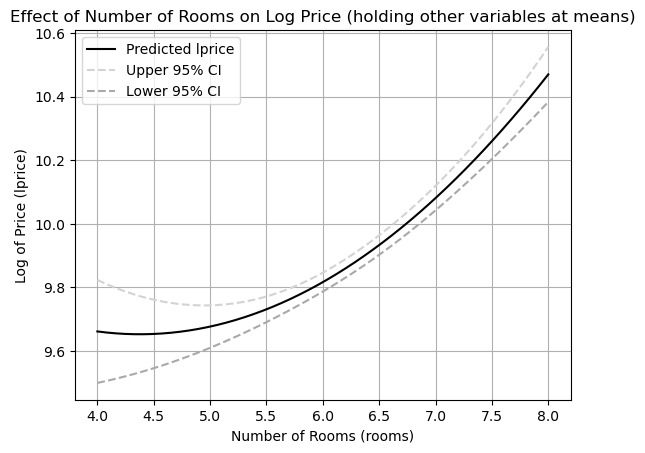

In [19]:
# plot:
plt.plot(
    X["rooms"],
    lpr_CI["mean"],
    color="black",
    linestyle="-",
    label="Predicted lprice",
)  # Plot predicted mean
plt.plot(
    X["rooms"],
    lpr_CI["mean_ci_upper"],
    color="lightgrey",
    linestyle="--",
    label="Upper 95% CI",  # Plot upper CI bound
)
plt.plot(
    X["rooms"],
    lpr_CI["mean_ci_lower"],
    color="darkgrey",
    linestyle="--",
    label="Lower 95% CI",  # Plot lower CI bound
)
plt.ylabel("Log of Price (lprice)")
plt.xlabel("Number of Rooms (rooms)")
plt.title("Effect of Number of Rooms on Log Price (holding other variables at means)")
plt.legend()
plt.grid(True)  # Add grid for better readability
plt.show()

**Interpretation of Effect Plot:**

The plot visually represents the inverted U-shaped relationship between the number of rooms and the log of housing price, as suggested by the regression coefficients.  The shaded area between the dashed lines represents the 95% confidence interval for the mean prediction.  This plot helps to understand the nonlinear effect of `rooms` on `lprice` and the uncertainty associated with these predictions. Effect plots are valuable tools for interpreting and presenting results from regression models with nonlinear specifications.